In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Uninstall packages from Kaggle base image that are not needed.
!pip uninstall -qy jupyterlab jupyterlab-lsp
# Install the google-genai SDK for this codelab.
!pip install -qU 'google-genai==1.7.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 6.3 MB/s eta 0:00:00


In [3]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

'1.7.0'

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

In [5]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [6]:
# Ask for information without search grounding.
response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="When and where is Billie Eilish's next concert?")

Markdown(response.text)

Unfortunately, I don't have access to real-time information, including Billie Eilish's constantly updating concert schedule.

Here's how you can find the most up-to-date information about her concert dates:

*   **Billie Eilish's Official Website:** This is the best place to start. Look for a "Tour" or "Events" section.
*   **Ticket Vendor Websites:** Check sites like Ticketmaster, Live Nation, etc. They will often have tour schedules listed when tickets go on sale.
*   **Social Media:** Follow Billie Eilish on her social media accounts (Instagram, Twitter/X, Facebook). She usually announces tour dates there.
*   **Google Search:** Search for "Billie Eilish tour dates" to see if any news articles or aggregated listings pop up.

In [7]:
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="When and where is Billie Eilish's next concert?",
    config=config_with_search,
)

rc = response.candidates[0]

Markdown(rc.content.parts[0].text)

Billie Eilish's next concert is on April 23, 2025, at the Avicii Arena in Stockholm, Sweden.


In [8]:
chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

ticketmaster.co.uk: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKgu8tpIN7ULkd3y0XAditIVxBWQf-E31bMC6qvMJnzUATaGz3SSoMga5a6JoT6XUFSlC4k0de6r8YuL_82e-8NUKPfeHDI5v6jIYrLArDchORXCgBGoy-k8BXp9-sGI863_r7_eA0UCGvj8bnRJXRWYg-ALcZUYUI68-76Tw==
ticketmaster.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKpYhGciBAJWTiQlHFFEV-mnCmHWVFiW8TtILepvy26DZvs7IJ5VpZlfYh0l1tZ4kKBw8qw9dAm19uFncgBriQNCi8tiYG2UfpvvzE64uHdaglExpRf-de4oaXCJ05wuWm7PhRs22i8xOTfFRGxo-2p7u2N7l1qwk6MJYM=


In [9]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

In [10]:
from pprint import pprint

supports = rc.grounding_metadata.grounding_supports
for support in supports:
    pprint(support.to_json_dict())

{'confidence_scores': [0.6205216, 0.7180642],
 'grounding_chunk_indices': [0, 1],
 'segment': {'end_index': 92,
             'text': "Billie Eilish's next concert is on April 23, 2025, at "
                     'the Avicii Arena in Stockholm, Sweden.'}}


In [11]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        response.text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

Supported text:

 * Billie Eilish's next concert is on April 23, 2025, at the Avicii Arena in Stockholm, Sweden.<sup>[1]</sup><sup>[2]</sup>

Citations:

1. [ticketmaster.co.uk](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKgu8tpIN7ULkd3y0XAditIVxBWQf-E31bMC6qvMJnzUATaGz3SSoMga5a6JoT6XUFSlC4k0de6r8YuL_82e-8NUKPfeHDI5v6jIYrLArDchORXCgBGoy-k8BXp9-sGI863_r7_eA0UCGvj8bnRJXRWYg-ALcZUYUI68-76Tw==)
2. [ticketmaster.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKpYhGciBAJWTiQlHFFEV-mnCmHWVFiW8TtILepvy26DZvs7IJ5VpZlfYh0l1tZ4kKBw8qw9dAm19uFncgBriQNCi8tiYG2UfpvvzE64uHdaglExpRf-de4oaXCJ05wuWm7PhRs22i8xOTfFRGxo-2p7u2N7l1qwk6MJYM=)


In [12]:
from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

In [13]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0,
)

chat = client.chats.create(model='gemini-2.0-flash')

response = chat.send_message(
    message="What were the medal tallies, by top-10 countries, for the 2024 olympics?",
    config=config_with_search,
)

show_response(response)

Here is the medal tally for the top 10 countries at the 2024 Paris Olympics:

1.  **United States:** 40 Gold, 44 Silver, 42 Bronze (126 total)
2.  **China:** 40 Gold, 27 Silver, 24 Bronze (91 total)
3.  **Japan:** 20 Gold, 12 Silver, 13 Bronze (45 total)
4.  **Australia:** 18 Gold, 19 Silver, 16 Bronze (53 total)
5.  **France:** 16 Gold, 26 Silver, 22 Bronze (64 total)
6.  **Netherlands:** 15 Gold, 7 Silver, 12 Bronze (34 total)
7.  **Great Britain:** 14 Gold, 22 Silver, 29 Bronze (65 total)
8.  **Republic of Korea:** 13 Gold, 9 Silver, 10 Bronze (32 total)
9.  **Italy:** 12 Gold, 13 Silver, 15 Bronze (40 total)
10. **Germany:** 12 Gold, 13 Silver, 8 Bronze (33 total)

----

Okay, I can help you visualize this data using a Seaborn chart. I'll use a stacked bar chart to represent the medal distribution for each country.



----

{'executable_code': {'code': "import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Data from the previous response\ndata = {\n    'Country': ['United States', 'China', 'Japan', 'Australia', 'France', 'Netherlands', 'Great Britain', 'Republic of Korea', 'Italy', 'Germany'],\n    'Gold': [40, 40, 20, 18, 16, 15, 14, 13, 12, 12],\n    'Silver': [44, 27, 12, 19, 26, 7, 22, 9, 13, 13],\n    'Bronze': [42, 24, 13, 16, 22, 12, 29, 10, 15, 8]\n}\n\ndf = pd.DataFrame(data)\n\n# Melt the dataframe to make it suitable for a stacked bar chart\ndf_melted = df.melt(id_vars='Country', var_name='Medal', value_name='Count')\n\n# Create the stacked bar chart\nplt.figure(figsize=(12, 8))  # Adjust figure size for better readability\nsns.barplot(x='Country', y='Count', hue='Medal', data=df_melted, palette={'Gold': 'gold', 'Silver': 'silver', 'Bronze': 'brown'}) # Use more descriptive colors\nplt.title('2024 Olympics Medal Tally (Top 10 Countries)', fontsize=16)\nplt.xlabel('Cou

----

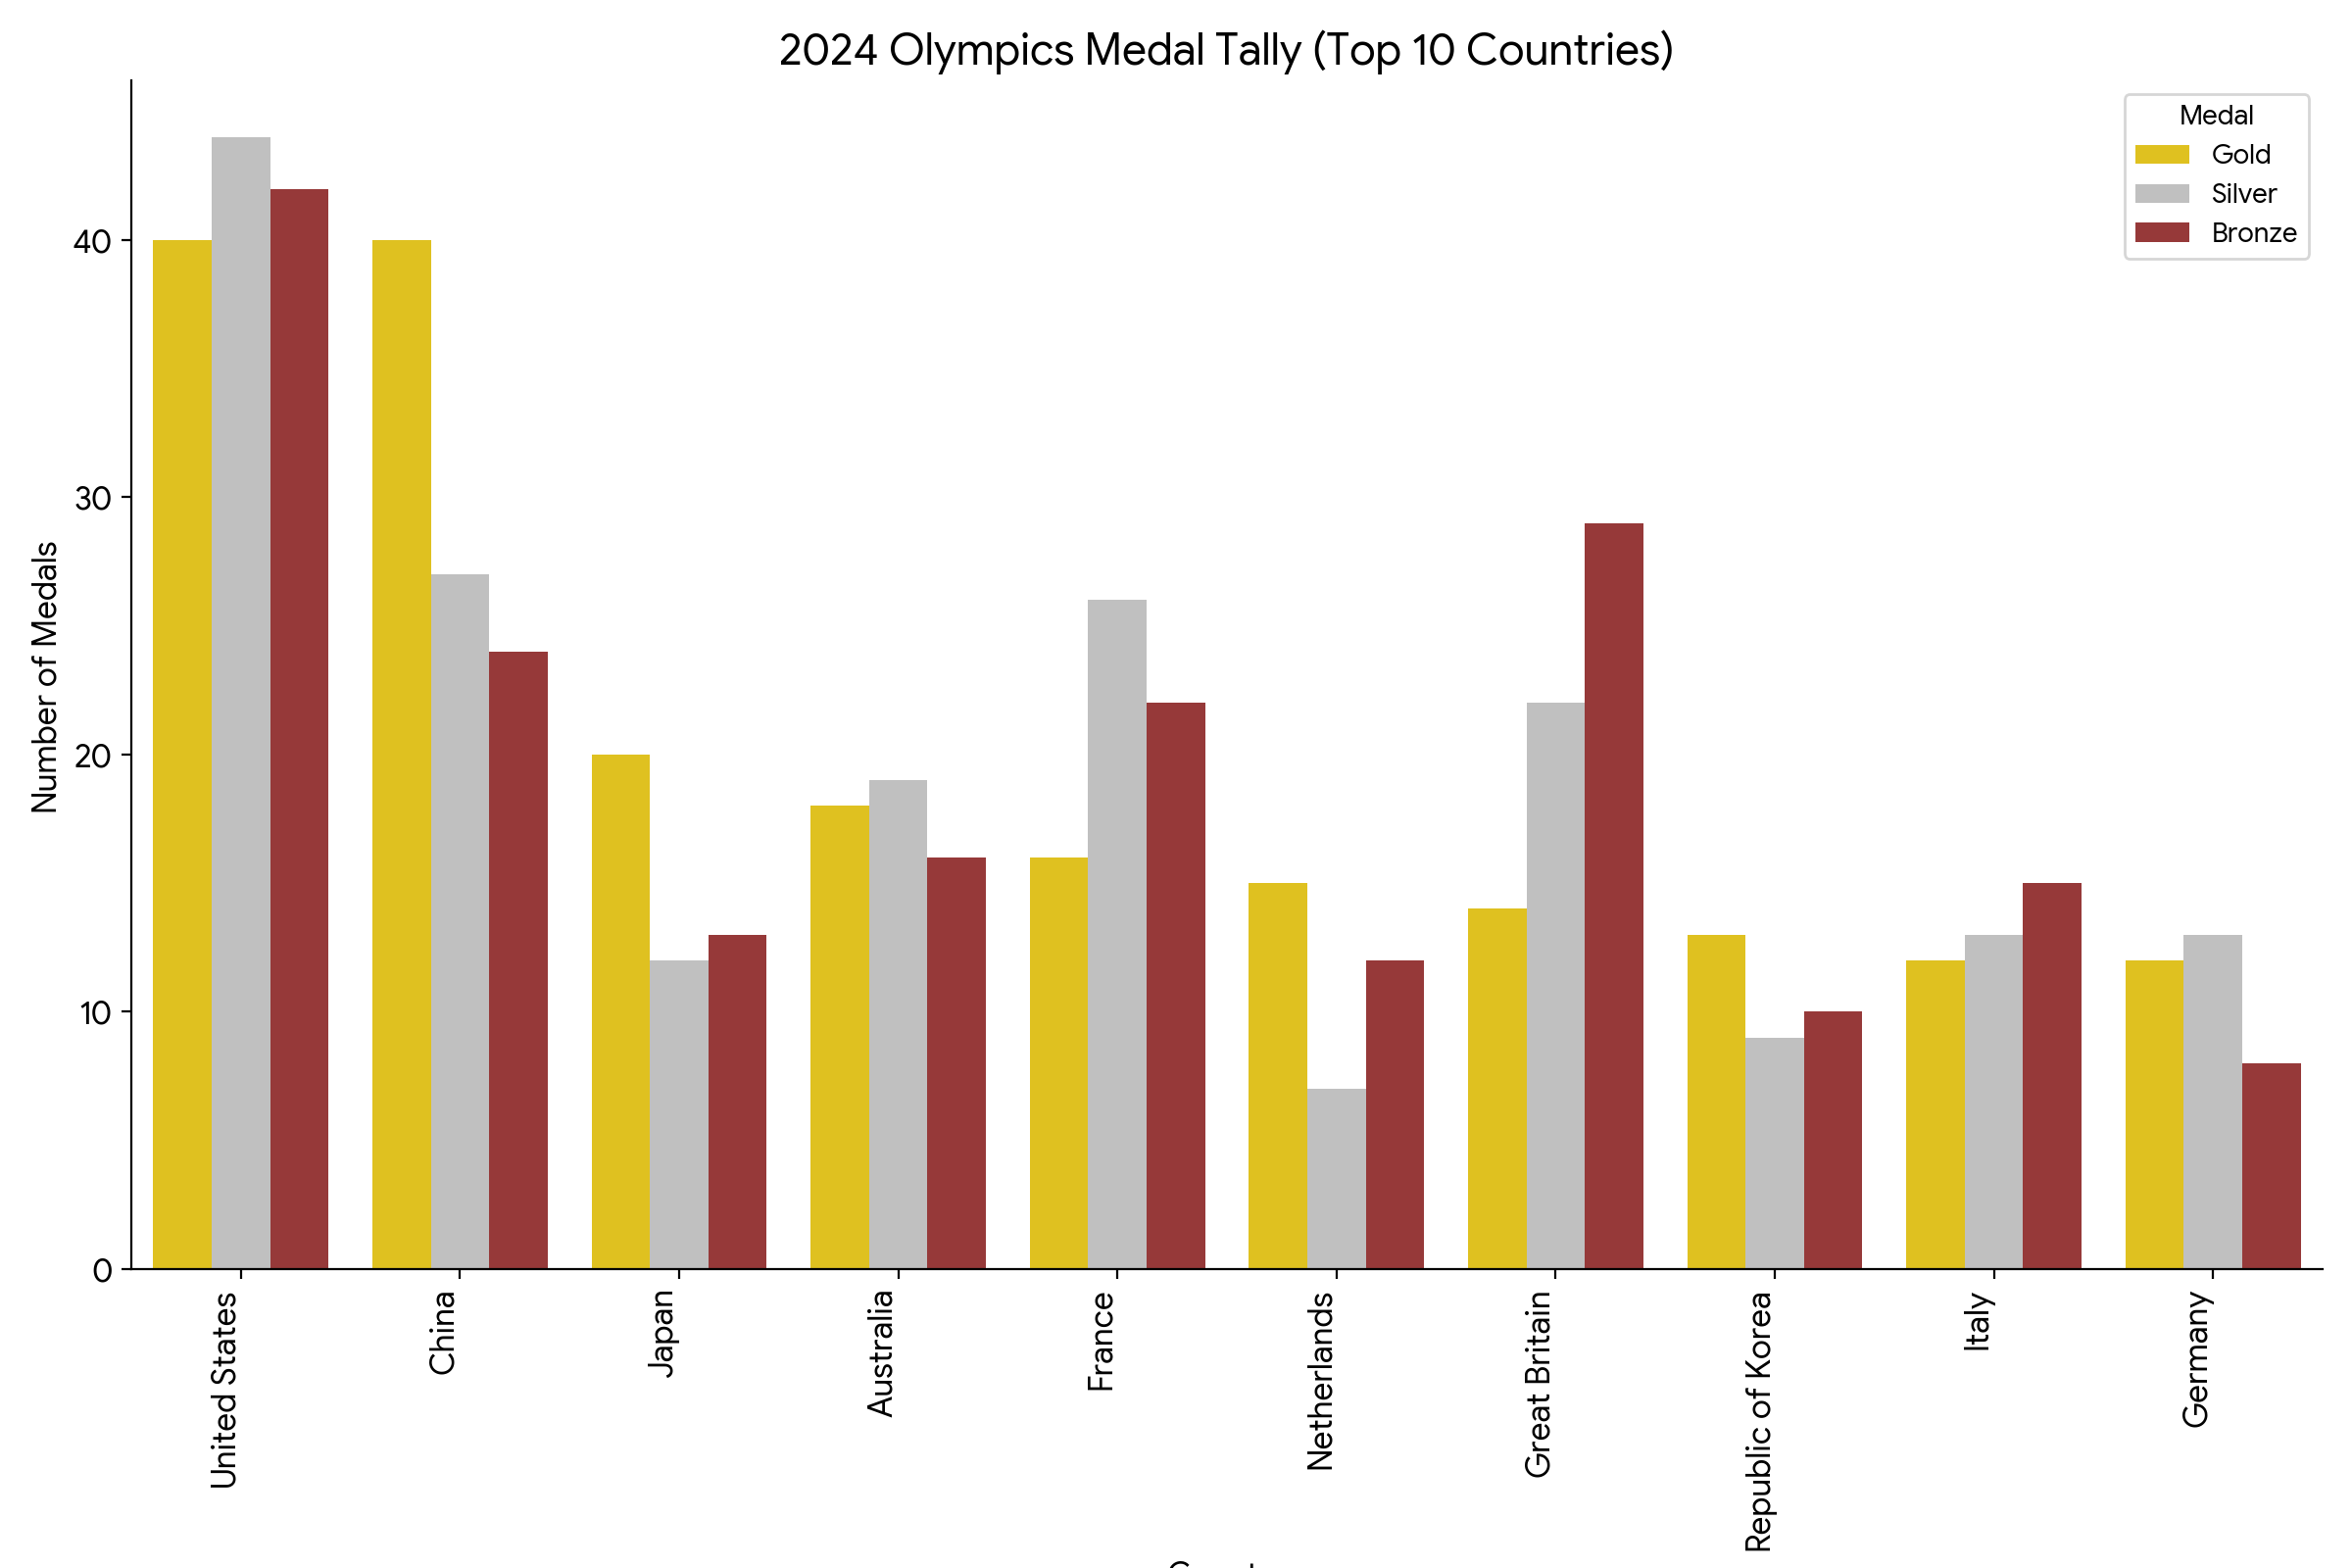

----

The chart displays the 2024 Olympics medal tally for the top 10 countries, broken down by medal type (Gold, Silver, and Bronze). The x-axis represents the countries, and the y-axis represents the number of medals. Each country has three bars representing the number of gold, silver, and bronze medals they won. The chart confirms the United States and China as the top two countries in terms of total medals. The x-axis labels are rotated for better readability. The colors used for each medal type are gold, silver, and brown.

----

In [14]:
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)

response = chat.send_message(
    message="Now plot this as a seaborn chart. Break out the medals too.",
    config=config_with_code,
)

show_response(response)